# VS of phenotypic compounds tested in SARS-CoV-2  by (M<sup>pro</sup>) QSAR models of SARS-CoV

## Importing modules and functions        
    

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import _pickle as cPickle
import gzip

from BalanceBySim import *
from stats import *

from collections import Counter

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.model_selection import permutation_test_score, StratifiedKFold

def warn(*args, **kwargs):
    pass
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%reload_ext autoreload
%autoreload 2
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Import screening data

In [2]:
# Set file path and format
file = 'datasets/curated_data/new_sars_cov_2_hits.sdf.gz'

# Read SDF
sdfInfo = dict(molColName='ROMol')
moldf = PandasTools.LoadSDF(file, **sdfInfo);
#print('Original data: ', moldf.shape)
# Rename ROMol
moldf = moldf.rename(columns={'ROMol': 'Mol'})
# Remove missing RDKit molecules
moldf = moldf[pd.notnull(moldf['Mol'])]
if 'StandardizerResult' in moldf.columns:
    moldf = moldf.drop(columns='StandardizerResult')

Kept data:  (7, 4)


,Compound_name,DRUGBANK_ID,ID,Mol
0,disulfiram,DB00822,,

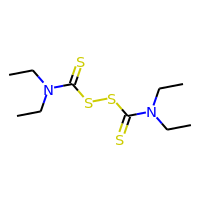


 Problematic structures: 
 []


In [3]:
# Columns
print('Kept data: ', moldf.shape)
moldf.head(1)
from molvs.validate import Validator
fmt = '%(asctime)s - %(levelname)s - %(validation)s - %(message)s'
validator = Validator(log_format=fmt)
print('\n Problematic structures: \n', validator.validate(moldf))

### Import SIRMS descriptors

##### Import descriptor of training set

In [4]:
train_desc = pd.read_csv('descriptors/sirms-chembl-sars-cov-3C-like-proteinase-processed.txt', sep='\t')
desc_list = train_desc.columns.tolist()
train_desc.head()

,Fr1(chg)/A,Fr1(chg)/B,Fr1(chg)/C,Fr1(elm)/Cl,Fr1(elm)/F,Fr1(elm)/N,Fr1(elm)/O,Fr1(elm)/S,Fr1(lip)/A,Fr1(lip)/B,Fr1(lip)/D,Fr1(rf)/C,Fr1(rf)/D,Fr1(type)/C.1,Fr1(type)/C.2,Fr1(type)/C.AR,Fr1(type)/N.1,Fr1(type)/N.2,Fr1(type)/N.AM,Fr1(type)/N.AR,Fr1(type)/N.PL3,Fr1(type)/O.3,Fr1(type)/S.O2,Fr2(chg)/A_B/1_2a/,Fr2(chg)/A_C/1_2a/,Fr2(chg)/A_C/1_2s/,Fr2(chg)/A_D/1_2a/,Fr2(chg)/B_B/1_2a/,Fr2(chg)/B_B/1_2d/,Fr2(chg)/B_B/1_2s/,Fr2(chg)/B_C/1_2a/,Fr2(chg)/B_D/1_2a/,Fr2(chg)/B_D/1_2s/,Fr2(chg)/C_C/1_2a/,Fr2(chg)/C_C/1_2s/,Fr2(chg)/C_D/1_2a/,Fr2(chg)/C_D/1_2d/,Fr2(chg)/C_D/1_2s/,Fr2(chg)/D_D/1_2a/,Fr2(chg)/D_D/1_2s/,Fr2(d_a)/I_I/1_2d/,Fr2(elm)/C_N/1_2d/,Fr2(elm)/C_O/1_2a/,Fr2(elm)/C_O/1_2s/,Fr2(elm)/C_S/1_2a/,Fr2(elm)/C_S/1_2s/,Fr2(elm)/H_O/1_2s/,Fr2(elm)/N_N/1_2a/,Fr2(elm)/N_O/1_2d/,Fr2(lip)/A_B/1_2s/,Fr2(lip)/A_C/1_2s/,Fr2(lip)/A_D/1_2a/,Fr2(lip)/A_D/1_2s/,Fr2(lip)/B_B/1_2a/,Fr2(lip)/B_C/1_2a/,Fr2(lip)/B_D/1_2a/,Fr2(lip)/B_D/1_2s/,Fr2(lip)/C_C/1_2a/,Fr2(lip)/C_D/1_2a/,Fr2(lip)/C_D/1_2s/,Fr2(lip)/D_D/1_2s/,Fr2(rf)/B_C/1_2s/,Fr2(type)/C.2_C.2/1_2s/,Fr2(type)/C.2_C.3/1_2s/,Fr2(type)/C.2_C.AR/1_2s/,Fr2(type)/C.2_CL/1_2s/,Fr2(type)/C.2_H/1_2s/,Fr2(type)/C.2_N.2/1_2s/,Fr2(type)/C.2_O.3/1_2s/,Fr2(type)/C.3_C.AR/1_2s/,Fr2(type)/C.3_N.3/1_2s/,Fr2(type)/C.3_O.3/1_2s/,Fr2(type)/C.3_S.3/1_2s/,Fr2(type)/C.AR_C.AR/1_2s/,Fr2(type)/C.AR_CL/1_2s/,Fr2(type)/C.AR_H/1_2s/,Fr2(type)/C.AR_N.AM/1_2s/,Fr2(type)/C.AR_O.3/1_2s/,Fr2(type)/C.AR_S.3/1_2s/,Fr2(type)/H_N.3/1_2s/,"Fr3(chg)/A_A_D/1_2a,2_3a/","Fr3(chg)/A_A_D/1_3a,2_3a/","Fr3(chg)/A_A_D/1_3d,2_3d/","Fr3(chg)/A_A_D/1_3s,2_3a/","Fr3(chg)/A_A_D/1_3s,2_3s/","Fr3(chg)/A_B_C/1_2s,2_3s/","Fr3(chg)/A_B_C/1_3a,2_3a/","Fr3(chg)/A_B_C/1_3s,2_3a/","Fr3(chg)/A_B_C/1_3s,2_3s/","Fr3(chg)/A_B_D/1_3a,2_3a/","Fr3(chg)/A_B_D/1_3a,2_3s/","Fr3(chg)/A_B_D/1_3d,2_3s/","Fr3(chg)/A_B_D/1_3s,2_3a/","Fr3(chg)/A_C_C/1_2a,1_3a/","Fr3(chg)/A_C_C/1_2s,1_3s/","Fr3(chg)/A_C_C/1_2s,2_3a/","Fr3(chg)/A_C_C/1_3a,2_3a/","Fr3(chg)/A_C_C/1_3a,2_3s/","Fr3(chg)/A_C_C/1_3d,2_3s/","Fr3(chg)/A_C_C/1_3s,2_3s/","Fr3(chg)/A_C_D/1_2a,1_3a/","Fr3(chg)/A_C_D/1_2a,2_3a/","Fr3(chg)/A_C_D/1_2a,2_3s/","Fr3(chg)/A_C_D/1_2s,1_3s/","Fr3(chg)/A_C_D/1_2s,2_3s/","Fr3(chg)/A_C_D/1_3a,2_3a/","Fr3(chg)/A_C_D/1_3a,2_3s/","Fr3(chg)/A_C_D/1_3d,2_3s/","Fr3(chg)/A_C_D/1_3s,2_3a/","Fr3(chg)/A_D_D/1_2a,1_3a/","Fr3(chg)/A_D_D/1_2s,1_3a/","Fr3(chg)/A_D_D/1_2s,2_3a/","Fr3(chg)/A_D_D/1_3a,2_3s/","Fr3(chg)/A_D_D/1_3d,2_3s/","Fr3(chg)/A_D_D/1_3t,2_3s/","Fr3(chg)/B_B_B/1_2s,2_3a/","Fr3(chg)/B_B_B/1_2s,2_3d/","Fr3(chg)/B_B_C/1_2a,2_3a/","Fr3(chg)/B_B_C/1_2s,2_3a/","Fr3(chg)/B_B_C/1_3a,2_3a/","Fr3(chg)/B_B_C/1_3s,2_3a/","Fr3(chg)/B_B_C/1_3s,2_3s/","Fr3(chg)/B_B_D/1_2a,1_3s/","Fr3(chg)/B_B_D/1_2a,2_3a/","Fr3(chg)/B_B_D/1_2s,2_3s/","Fr3(chg)/B_B_D/1_3a,2_3a/","Fr3(chg)/B_B_D/1_3s,2_3a/","Fr3(chg)/B_B_D/1_3s,2_3s/","Fr3(chg)/B_C_C/1_2a,1_3a/","Fr3(chg)/B_C_C/1_3a,2_3a/","Fr3(chg)/B_C_C/1_3a,2_3s/","Fr3(chg)/B_C_C/1_3s,2_3s/","Fr3(chg)/B_C_D/1_2a,1_3a/","Fr3(chg)/B_C_D/1_2a,2_3a/","Fr3(chg)/B_C_D/1_2a,2_3s/","Fr3(chg)/B_C_D/1_2s,2_3s/","Fr3(chg)/B_C_D/1_3a,2_3a/","Fr3(chg)/B_C_D/1_3a,2_3s/","Fr3(chg)/B_C_D/1_3s,2_3s/","Fr3(chg)/B_D_D/1_2a,1_3a/","Fr3(chg)/B_D_D/1_3a,2_3a/","Fr3(chg)/B_D_D/1_3a,2_3s/","Fr3(chg)/C_C_D/1_2d,1_3s/","Fr3(chg)/C_C_D/1_2s,2_3s/","Fr3(chg)/C_C_D/1_3s,2_3s/","Fr3(chg)/C_D_D/1_2s,1_3a/","Fr3(chg)/C_D_D/1_3a,2_3s/","Fr3(chg)/D_D_D/1_2s,2_3a/","Fr3(chg)/D_D_D/1_3s,2_3s/","Fr3(d_a)/A_A_I/1_3a,2_3a/","Fr3(d_a)/A_D_D/1_2s,1_3s/","Fr3(d_a)/A_I_I/1_2s,2_3a/","Fr3(d_a)/D_I_I/1_2s,2_3a/","Fr3(elm)/Br_C_C/1_2s,2_3a/","Fr3(elm)/C_C_C/1_2s,2_3a/","Fr3(elm)/C_C_F/1_2a,1_3s/","Fr3(elm)/C_C_I/1_2a,1_3s/","Fr3(elm)/C_C_N/1_2a,1_3s/","Fr3(elm)/C_C_N/1_2s,2_3a/","Fr3(elm)/C_C_N/1_3s,2_3a/","Fr3(elm)/C_C_O/1_2s,2_3s/","Fr3(elm)/C_C_O/1_3s,2_3s/","Fr3(elm)/C_C_S/1_2s,2_3s/","Fr3(elm)/C_H_N/1_2s,1_3a/","Fr3(elm)/C_H_N/1_2s,1_3s/","Fr3(elm)/C_H_S/1_2s,1_3a/","Fr3(elm)/C_N_N/1_2s,1_3a/","Fr3(elm)/C_N_S/1_2a,1_3a/","Fr3(lip)/A_B_C/1_2s,1_3a/","Fr3(lip)/A_B_C/1_2s,1_3s/","Fr3(lip)/A_B_C/

##### Import descriptor of VS set

In [5]:
vs_desc = pd.read_csv('descriptors/sirms-new-phen-covid2.txt', sep='\t')
vs_desc.drop(vs_desc.columns[0:2], axis=1,inplace=True)
vs_desc.head()

Fr1(chg)/A  Fr1(chg)/B  Fr1(chg)/C  Fr1(chg)/D  Fr2(chg)/A_B/1_2s/  Fr2(chg)/A_C/1_2a/  Fr2(chg)/A_C/1_2s/  Fr2(chg)/A_D/1_2a/  Fr2(chg)/A_D/1_2d/  Fr2(chg)/A_D/1_2s/  Fr2(chg)/B_B/1_2a/  Fr2(chg)/B_B/1_2d/  Fr2(chg)/B_B/1_2s/  Fr2(chg)/B_C/1_2a/  Fr2(chg)/B_C/1_2s/  Fr2(chg)/B_D/1_2a/  Fr2(chg)/B_D/1_2s/  Fr2(chg)/C_C/1_2a/  Fr2(chg)/C_C/1_2s/  Fr2(chg)/C_D/1_2a/  Fr2(chg)/C_D/1_2d/  Fr2(chg)/C_D/1_2s/  Fr2(chg)/D_D/1_2s/  Fr3(chg)/A_A_D/1_3a,2_3a/  Fr3(chg)/A_A_D/1_3s,2_3d/  Fr3(chg)/A_A_D/1_3s,2_3s/  Fr3(chg)/A_B_C/1_2s,1_3s/  Fr3(chg)/A_B_C/1_2s,2_3s/  Fr3(chg)/A_B_C/1_3s,2_3a/  Fr3(chg)/A_B_C/1_3s,2_3s/  Fr3(chg)/A_B_D/1_2s,1_3s/  Fr3(chg)/A_B_D/1_3a,2_3s/  Fr3(chg)/A_B_D/1_3d,2_3s/  Fr3(chg)/A_B_D/1_3s,2_3a/  Fr3(chg)/A_B_D/1_3s,2_3s/  Fr3(chg)/A_C_C/1_2s,1_3s/  Fr3(chg)/A_C_C/1_2s,2_3a/  Fr3(chg)/A_C_C/1_3a,2_3a/  Fr3(chg)/A_C_C/1_3a,2_3s/  Fr3(chg)/A_C_C/1_3s,2_3s/  Fr3(chg)/A_C_D/1_2a,1_3a/  Fr3(chg)/A_C_D/1_2a,1_3s/  Fr3(chg)/A_C_D/1_2s,1_3s/  Fr3(chg)/A_C_D/1_2s,2_3d/  Fr3(chg)/A_C_D/1_2s,2_3s/  Fr3(chg)/A_C_D/1_3d,2_3s/  Fr3(chg)/A_C_D/1_3s,2_3a/  Fr3(chg)/A_C_D/1_3s,2_3d/  Fr3(chg)/A_C_D/1_3s,2_3s/  Fr3(chg)/A_D_D/1_2s,1_3a/  Fr3(chg)/A_D_D/1_2s,1_3s/  Fr3(chg)/A_D_D/1_3d,2_3s/  Fr3(chg)/A_D_D/1_3s,2_3s/  Fr3(chg)/B_B_B/1_2s,2_3d/  Fr3(chg)/B_B_B/1_3a,2_3a/  Fr3(chg)/B_B_B/1_3s,2_3s/  Fr3(chg)/B_B_C/1_2a,1_3s/  Fr3(chg)/B_B_C/1_2a,2_3a/  Fr3(chg)/B_B_C/1_2d,1_3s/  Fr3(chg)/B_B_C/1_2s,2_3s/  Fr3(chg)/B_B_C/1_3a,2_3a/  Fr3(chg)/B_B_C/1_3s,2_3a/  Fr3(chg)/B_B_C/1_3s,2_3s/  Fr3(chg)/B_B_D/1_2a,2_3a/  Fr3(chg)/B_B_D/1_2d,1_3s/  Fr3(chg)/B_B_D/1_2s,2_3s/  Fr3(chg)/B_B_D/1_3s,2_3s/  Fr3(chg)/B_C_C/1_2s,1_3a/  Fr3(chg)/B_C_C/1_2s,1_3s/  Fr3(chg)/B_C_C/1_2s,2_3a/  Fr3(chg)/B_C_C/1_3a,2_3a/  Fr3(chg)/B_C_C/1_3s,2_3s/  Fr3(chg)/B_C_D/1_2a,2_3s/  Fr3(chg)/B_C_D/1_2s,1_3a/  Fr3(chg)/B_C_D/1_2s,1_3s/  Fr3(chg)/B_C_D/1_3a,2_3a/  Fr3(chg)/B_C_D/1_3s,2_3s/  Fr3(chg)/B_D_D/1_2s,1_3s/  Fr3(chg)/C_C_C/1_2s,2_3a/  Fr3(chg)/C_C_C/1_3s,2_3s/  Fr3(chg)/C_C_D/1_2a,1_3s/  Fr3(chg)/C_C_D/1_2a,2_3a/  Fr3(chg)/C_C_D/1_2s,2_3d/  Fr3(chg)/C_D_D/1_2s,1_3a/  Fr3(chg)/C_D_D/1_3d,2_3s/  S_A(chg)/A_A_A_D/1_4s,2_4s,3_4d/5  S_A(chg)/A_A_A_D/2_4s,3_4d/4  S_A(chg)/A_A_A_D/2_4s,3_4s/4  S_A(chg)/A_A_B_C/2_3s,2_4s/4  S_A(chg)/A_A_B_C/2_3s,3_4s/4  S_A(chg)/A_A_B_C/2_4s,3_4a/4  S_A(chg)/A_A_B_C/2_4s,3_4s/4  S_A(chg)/A_A_B_D/1_3s,1_4s,2_4d/6  S_A(chg)/A_A_B_D/1_4a,2_4a,3_4s/5  S_A(chg)/A_A_B_D/1_4a,2_4a/4  S_A(chg)/A_A_B_D/1_4s,2_4d,3_4s/5  S_A(chg)/A_A_B_D/1_4s,2_4d/4  S_A(chg)/A_A_B_D/1_4s,2_4s/4  S_A(chg)/A_A_B_D/2_4d,3_4s/4  S_A(chg)/A_A_B_D/2_4s,3_4a/4  S_A(chg)/A_A_B_D/2_4s,3_4s/4  S_A(chg)/A_A_C_C/1_3a,2_4a,3_4a/6  S_A(chg)/A_A_C_C/1_3s,2_4s/3  S_A(chg)/A_A_C_C/2_3s,2_4s/4  S_A(chg)/A_A_C_C/2_3s,3_4a/4  S_A(chg)/A_A_C_C/2_4a,3_4s/4  S_A(chg)/A_A_C_C/2_4s,3_4s/4  S_A(chg)/A_A_C_D/1_3s,1_4s,2_4d/6  S_A(chg)/A_A_C_D/1_3s,2_4d,3_4s/6  S_A(chg)/A_A_C_D/1_3s,2_4d/3  S_A(chg)/A_A_C_D/1_3s,2_4s,3_4d/6  S_A(chg)/A_A_C_D/1_3s,2_4s,3_4s/6  S_A(chg)/A_A_C_D/1_3s,2_4s/3  S_A(chg)/A_A_C_D/1_4a,2_3a,2_4a/6  S_A(chg)/A_A_C_D/1_4a,2_4a/4  S_A(chg)/A_A_C_D/1_4s,2_3a/3  S_A(chg)/A_A_C_D/1_4s,2_3s,2_4s/6  S_A(chg)/A_A_C_D/1_4s,2_4d,3_4s/5  S_A(chg)/A_A_C_D/1_4s,2_4d/4  S_A(chg)/A_A_C_D/1_4s,2_4s/4  S_A(chg)/A_A_C_D/2_3a,2_4s/4  S_A(chg)/A_A_C_D/2_3s,2_4s/4  S_A(chg)/A_A_C_D/2_3s,3_4d/4  S_A(chg)/A_A_C_D/2_3s,3_4s/4  S_A(chg)/A_A_C_D/2_4d,3_4s/4  S_A(chg)/A_A_C_D/2_4s,3_4a/4  S_A(chg)/A_A_C_D/2_4s,3_4d/4  S_A(chg)/A_A_C_D/2_4s,3_4s/4  S_A(chg)/A_A_D_D/1_3d,2_4d/3  S_A(chg)/A_A_D_D/1_3s,1_4a,2_4a/6  S_A(chg)/A_A_D_D/1_3s,1_4s,2_4d/6  S_A(chg)/A_A_D_D/1_3s,2_4d,3_4s/6  S_A(chg)/A_A_D_D/1_3s,2_4d/3  S_A(chg)/A_A_D_D/1_3s,2_4s,3_4s/6  S_A(chg)/A_A_D_D/1_3s,2_4s/3  S_A(chg)/A_A_D_D/1_4s,2_3s,2_4s/6  S_A(chg)/A_A_D_D/1_4s,2_4d,3_4s/5  S_A(chg)/A_A_D_D/1_4s,2_4d/4  S_A(chg)/A_A_D_D/1_4s,2_4s/4  S_A(chg)/A_A_D_D/2_3s,2_4s/4  S_A(chg)/A_A_D_D/2_4d,3_4s/4  S_A(chg)/A_A_D_D/2_4s,3_4s/4  S_A(chg)/A_B_B_B/1_2s,3_4a/3  S_A(chg)/A_B_B_B/2_3s,3_4d/4  S_A(chg)/A_B_B_B/2_4a,3_4a/4  S_A(chg)

#### Filter out descriptors not present in the model

In [6]:
miss_desc = train_desc.columns.difference(vs_desc.columns).tolist()
miss_desc = pd.DataFrame([[0]*len(miss_desc)]*vs_desc.shape[0], columns=miss_desc)
vs_desc = pd.concat([vs_desc, miss_desc], axis=1)
X_vs = vs_desc[desc_list]
X_vs.shape

(7, 1262)

# Virtual screening SiRMS

##### Load the model

In [7]:
with gzip.open('model/sars-cov-3clpro-sirms_RF_ad_balanced.pgz', 'rb') as f:
    model = cPickle.load(f)

##### Predict molecules

In [8]:
%%time
ad_threshold = 0.70

y_pred = model.predict(X_vs)
ad = model.predict_proba(X_vs)
ad = np.amax(ad, axis=1) >= ad_threshold

CPU times: user 42.4 ms, sys: 4.36 ms, total: 46.7 ms
Wall time: 212 ms


In [9]:
pred = pd.DataFrame({'Prediction': y_pred,'AD': ad}, index=None)
pred.AD[pred.AD == False] = np.nan
pred.AD[pred.AD == True] = pred.Prediction.astype(int)

In [10]:
pred_ad = pred.dropna().astype(int)
coverage_ad = len(pred_ad) * 100 / len(pred)

print('VS pred: %s' % Counter(pred.Prediction))
print('VS pred AD: %s' % Counter(pred_ad.Prediction))
print('Coverage of AD: %.2f%%' % coverage_ad)

VS pred: Counter({0: 7})
VS pred AD: Counter({0: 3})
Coverage of AD: 42.86%


###  Visualize predictions

,Compound_name,DRUGBANK_ID,ID,Mol,AD,Prediction
0,disulfiram,DB00822,,,NaN,0
1,carmofur,DB09010,,,NaN,0
2,ebselen,DB12610,,,0.0,0
3,shikonin,,,,0.0,0
4,tideglusib,DB12129,,,NaN,0

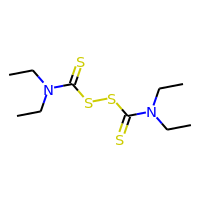
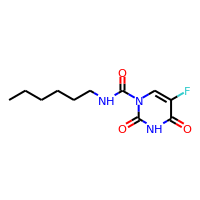
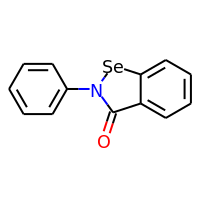
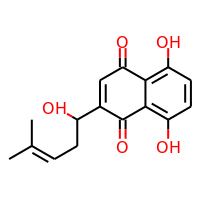
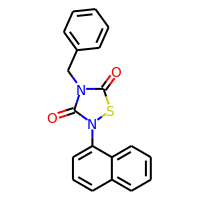

In [11]:
sirms_predictions = pd.concat([moldf, pred], axis=1)
sirms_predictions.head()

### Import DRAGON descriptors

##### Import descriptor of training set

In [12]:
train_desc = pd.read_csv('descriptors/dragon-chembl-sars-cov-3C-like-proteinase-processed.txt', sep='\t')
desc_list = train_desc.columns.tolist()
train_desc.head()

,AECC,ALOGP,ALOGP2,AMW,ATS4m,ATSC1s,ATSC3e,B01[C-Cl],B01[C-S],B01[N-O],B01[O-S],B02[N-N],B02[N-O],B02[N-S],B02[O-O],B03[N-N],B03[N-O],B03[N-S],B03[O-O],B03[O-S],B04[N-N],B04[N-O],B04[N-S],B04[O-O],B04[O-S],B05[C-Cl],B05[C-N],B05[N-N],B05[N-O],B05[N-S],B05[O-O],B05[O-S],B06[C-N],B06[C-S],B06[N-N],B06[N-O],B06[N-S],B06[O-Cl],B06[O-O],B06[O-S],B07[C-N],B07[N-O],B07[O-Cl],B07[O-O],B07[O-S],B08[C-Cl],B08[C-N],B08[C-O],B08[C-S],B08[N-N],B08[N-O],B08[O-O],B09[C-C],B09[C-O],B09[C-S],B09[N-N],B09[N-O],B09[O-S],B10[C-C],B10[C-Cl],B10[C-N],B10[C-O],B10[C-S],B10[N-O],B10[O-O],C%,C-001,C-002,C-003,C-005,C-006,C-016,C-017,C-019,C-024,C-025,C-026,C-027,C-028,C-032,C-033,C-034,C-035,C-039,C-040,C-041,C-043,CATS2D_00_AA,CATS2D_00_DA,CATS2D_00_DP,CATS2D_00_LL,CATS2D_01_AA,CATS2D_01_AN,CATS2D_01_LL,CATS2D_02_AA,CATS2D_02_AL,CATS2D_02_DL,CATS2D_02_PL,CATS2D_03_AA,CATS2D_03_AL,CATS2D_03_DL,CATS2D_03_LL,CATS2D_03_NL,CATS2D_03_PL,CATS2D_04_AA,CATS2D_04_AL,CATS2D_04_AP,CATS2D_04_DA,CATS2D_04_DD,CATS2D_04_DL,CATS2D_04_LL,CATS2D_04_PL,CATS2D_05_AA,CATS2D_05_AL,CATS2D_05_DD,CATS2D_05_DL,CATS2D_05_DP,CATS2D_05_LL,CATS2D_06_AA,CATS2D_06_AL,CATS2D_06_AP,CATS2D_06_DA,CATS2D_06_LL,CATS2D_07_AA,CATS2D_07_AL,CATS2D_07_DA,CATS2D_07_DL,CATS2D_07_LL,CATS2D_07_NL,CATS2D_08_AL,CATS2D_08_LL,CATS2D_08_PL,CATS2D_09_AA,CATS2D_09_AL,CATS2D_09_DA,CATS2D_09_LL,CATS2D_09_NL,CATS2D_09_PL,CIC2,CIC3,CMC-50,CMC-80,Chi0_EA(dm),Chi_D/Dt,Cl-090,D/Dtr03,D/Dtr05,D/Dtr06,D/Dtr09,D/Dtr10,DLS_05,DLS_07,Depressant-80,EE_B(m),EE_B(s),Eig01_AEA(dm),Eig01_AEA(ed),Eig01_EA(bo),Eig01_EA(dm),Eig02_AEA(dm),Eig02_AEA(ed),Eig02_EA(dm),Eig03_AEA(dm),Eig03_AEA(ed),Eig03_EA(dm),Eig04_AEA(ed),Eig04_EA(bo),Eig04_EA(dm),Eig05_AEA(ed),Eta_betaP,F-083,F01[C-Cl],F01[C-N],F01[C-O],F01[C-S],F01[N-N],F02[C-Br],F02[C-O],F02[C-S],F02[N-N],F02[O-O],F03[C-N],F03[C-O],F03[C-S],F03[N-F],F03[N-N],F03[N-S],F04[C-Br],F04[C-O],F04[N-F],F04[N-N],F04[N-O],F04[O-O],F04[O-S],F05[C-S],F05[N-F],F05[N-N],F05[O-Br],F05[S-F],F06[C-F],F06[C-N],F06[C-O],F06[C-S],F06[N-F],F06[N-N],F06[N-S],F06[O-F],F06[O-O],F06[O-S],F06[S-F],F06[S-S],F07[C-S],F07[N-N],F07[N-O],F07[O-Cl],F07[O-F],F07[O-S],F08[C-F],F08[C-S],F08[N-Cl],F08[N-F],F08[N-N],F08[N-S],F08[O-F],F08[S-Cl],F09[C-F],F09[C-S],F09[N-Cl],F09[N-F],F09[N-N],F09[N-S],F09[O-Cl],F09[O-O],F09[O-S],F10[C-Cl],F10[C-I],F10[C-S],F10[N-Cl],F10[N-F],F10[N-N],F10[N-O],F10[O-O],GATS6e,GATS7e,GATS8e,GATS8m,GGI3,GGI5,H%,H-046,H-047,H-048,H-049,H-051,H-052,Hypertens-80,Hypnotic-80,IC2,IDDE,Infective-50,Infective-80,Inflammat-50,Inflammat-80,J_D,J_D/Dt,LOC,MAXDN,MLOGP2,MPC05,N%,N-067,N-073,N-074,N-075,NRS,NaaO,NaaS,NaaaC,NaasC,NaasN,NdO,NdsCH,NdssC,Neoplastic-50,Neoplastic-80,NssO,NsssN,NssssC,NtN,NtsC,O%,O-060,PCD,P_VSA_LogP_3,P_VSA_LogP_4,P_VSA_LogP_5,P_VSA_LogP_6,P_VSA_LogP_8,P_VSA_MR_3,P_VSA_MR_6,P_VSA_MR_7,P_VSA_MR_8,P_VSA_e_2,P_VSA_e_3,P_VSA_i_1,P_VSA_i_2,P_VSA_m_4,P_VSA_m_5,P_VSA_p_3,P_VSA_ppp_L,P_VSA_ppp_ar,P_VSA_ppp_con,P_VSA_ppp_hal,P_VSA_s_3,P_VSA_s_4,Psychotic-80,Rperim,SM02_EA(dm),SM03_EA(dm),SM03_EA(ed),SM05_EA(bo),SRW05,SaaNH,SaasC,SdNH,SdssC,SpAD_EA(dm),SpDiam_B(s),SpMAD_Dt,SpMAD_EA(ed),SpMax2_Bh(m),SpMax2_Bh(s),SpMax3_Bh(s),SpMax6_Bh(s),SssCH2,T(Cl..I),T(F..Cl),T(F..I),T(N..Br),T(N..Cl),T(N..F),T(N..I),T(N..N),T(N..S),T(O..F),T(O..S),T(S..Cl),T(S..I),TI1_L,Uc,VE1_A,VE1_B(e),VE1_B(m),VE1_B(p),VE1_B(s),VE1_X,VE3sign_B(e),VE3sign_B(m),VE3sign_B(p),VE3sign_B(s),VE3sign_B(v),Wap,X%,ZM1Mad,nArOR,nArX,nBnz,nCb-,nCconj,nCrs,nCrt,nCsp2,nR06,nR=Cs,nRCONR2,nRCOOR,nThiophenes,piPC08
0,14.718,-1.294,1.675,6.897,4.419,26.457,1.207,0,0,0,0,1,1,0,0,1,1,0,0,0,1,1,0,1,0,0,1,1,1,0,1,0,1,0,1,1,0,0,0,0,1,1,0,1,0,0,1,1,0,1,1,1,1,1,0,1,1,0,1,0,1,1,0,1,1,31.3,6,2,2,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,5,0,0,8,1,0,10,0,0,5,0,1,6,0,0,5,6,0,0,0,1,7,0,2,2,5,0,0,6,7,0,8,0,3,1,6,0,5,6,2,7,2,5,7,0,7,6,0,0,6,4,3,0,0,1.672,1.027,0,0,23.731,1.075,0,0.0,154.997,0.000,0.000,0.0,1.0,0.0,0,5.812,9.320,3.861,6.393,3.493,2.004,3.791,6.097,1.980,3.700,6.055,1.946,5.781,3.071,1.911,5.558,13.0,0,0,14,7,0,0,0,7,0,1,0,10,11,0,0,4

##### Import descriptor of VS set

In [13]:
vs_desc = pd.read_csv('descriptors/dragon-new-phen-covid2.txt', sep='\t')
vs_desc.drop(vs_desc.columns[0:1], axis=1,inplace=True)
vs_desc.head()

MW     AMW      Sv      Se      Sp      Si     Mv     Me     Mp     Mi     GD  nAT  nSK  nTA  nBT  nBO  nBM  SCBO  RBN    RBF  nDB  nTB  nAB  nH  nC  nN  nO  nP  nS  nF  nCL  nBR  nI  nB  nHM  nHet  nX    H%    C%   N%    O%   X%  nCsp3  nCsp2  nCsp  nStructures  totalcharge  nCIC  nCIR  TRS  Rperim  Rbrid    MCD    RFD    RCI  NRS   NNRS  nR03  nR04  nR05  nR06  nR07  nR08  nR09  nR10  nR11  nR12  nBnz    ARR  D/Dtr03  D/Dtr04  D/Dtr05  D/Dtr06  D/Dtr07  D/Dtr08  D/Dtr09  D/Dtr10  D/Dtr11  D/Dtr12  ZM1  ZM1V   ZM1Kup   ZM1Mad  ZM1Per  ZM1MulPer  ZM2  ZM2V   ZM2Kup   ZM2Mad  ZM2Per  ZM2MulPer     ON0   ON0V    ON1   ON1V  Qindex  BBI    DBI    SNar   HNar   GNar     Xt  Dz  Ram    BLI  Pol     LPRS    MSD     SPI  PJI2  ECC   AECC   DECC    MDDD  UNIP  CENT  VAR    ICR  SMTI  SMTIV  GMTI  GMTIV      Xu  CSI    Wap     S1K    S2K    S3K     PHI    PW2    PW3    PW4    PW5  MAXDN  MAXDP    DELS     TIE  Psi_i_s  Psi_i_A  Psi_i_0  Psi_i_1  Psi_i_t  Psi_i_0d  Psi_i_1d  Psi_i_1s  Psi_e_A  Psi_e_0  Psi_e_1  Psi_e_t  Psi_e_0d Psi_e_1d Psi_e_1s  BAC    LOC  MWC01  MWC02  MWC03  MWC04  MWC05  MWC06  MWC07   MWC08   MWC09   MWC10  SRW02  SRW03  SRW04  SRW05  SRW06  SRW07  SRW08  SRW09   SRW10  MPC01  MPC02  MPC03  MPC04  MPC05  MPC06  MPC07  MPC08  MPC09  MPC10  piPC01  piPC02  piPC03  piPC04  piPC05  piPC06  piPC07  piPC08  piPC09  piPC10     TWC    TPC    piID    PCR    PCD    CID    BID      X0      X1      X2     X3     X4     X5    X0A    X1A    X2A    X3A    X4A    X5A     X0v    X1v    X2v    X3v    X4v    X5v   X0Av   X1Av   X2Av   X3Av   X4Av   X5Av   X0sol   X1sol   X2sol   X3sol  X4sol  X5sol    XMOD  RDCHI     RDSQ  X1Kup   X1Mad  X1Per  X1MulPer     ISIZ     IAC    AAC    IDE    IDM   IDDE   IDDM     IDET       IDMT   IVDE   IVDM  Ges   rGes      S0K  HVcpx  HDcpx  Uindex  Vindex  Xindex  Yindex    IC0    IC1    IC2    IC3    IC4    IC5    TIC0     TIC1     TIC2     TIC3     TIC4     TIC5   SIC0   SIC1   SIC2   SIC3   SIC4   SIC5   CIC0   CIC1   CIC2   CIC3   CIC4   CIC5   BIC0   BIC1   BIC2   BIC3   BIC4   BIC5       J_A  SpPos_A  SpPosA_A  SpPosLog_A  SpMax_A  SpMaxA_A  SpDiam_A  SpAD_A  SpMAD_A    Ho_A   EE_A  VE1_A  VE2_A  VE3_A  VE1sign_A  VE2sign_A VE3sign_A   VR1_A  VR2_A  VR3_A  Wi_D  WiA_D    AVS_D     H_D  Chi_D  ChiA_D     J_D  HyWi_D  SpPos_D  SpPosA_D  SpPosLog_D  SpMax_D  SpMaxA_D  SpDiam_D   SpAD_D  SpMAD_D    Ho_D     EE_D  SM2_D   SM3_D   SM4_D   SM5_D   SM6_D  VE1_D  VE2_D  VE3_D  VE1sign_D  VE2sign_D VE3sign_D   VR1_D  VR2_D  VR3_D     QW_L    TI1_L  TI2_L  STN_L  SpPos_L  SpPosA_L  SpPosLog_L  SpMax_L  SpMaxA_L  SpDiam_L  SpAD_L  SpMAD_L    Ho_L   EE_L  SM2_L  SM3_L  SM4_L  SM5_L   SM6_L  VE1_L  VE2_L  VE3_L  VE1sign_L  VE2sign_L  VE3sign_L   VR1_L  VR2_L  VR3_L  AVS_X     H_X   Chi_X  ChiA_X       J_X  HyWi_X  SpPos_X  SpPosA_X  SpPosLog_X  SpMax_X  SpMaxA_X  SpDiam_X  SpAD_X  SpMAD_X   Ho_X   EE_X  SM2_X  SM3_X  SM4_X  SM5_X  SM6_X  VE1_X  VE2_X  VE3_X  VE1sign_X  VE2sign_X VE3sign_X   VR1_X  VR2_X  VR3_X   Wi_H2  WiA_H2  AVS_H2  Chi_H2  ChiA_H2     J_H2  HyWi_H2  SpPos_H2  SpPosA_H2  SpPosLog_H2  SpMax_H2  SpMaxA_H2  SpDiam_H2  SpAD_H2  SpMAD_H2   Ho_H2  EE_H2  SM2_H2  SM3_H2  SM4_H2  SM5_H2  SM6_H2  VE1_H2  VE2_H2  VE3_H2  VE1sign_H2  VE2sign_H2 VE3sign_H2  VR1_H2  VR2_H2  VR3_H2  Wi_Dt  WiA_Dt   AVS_Dt    H_Dt  Chi_Dt  ChiA_Dt    J_Dt  HyWi_Dt  SpPos_Dt  SpPosA_Dt  SpPosLog_Dt  SpMax_Dt  SpMaxA_Dt  SpDiam_Dt  SpAD_Dt  SpMAD_Dt   Ho_Dt    EE_Dt  SM2_Dt  SM3_Dt  SM4_Dt  SM5_Dt  SM6_Dt  VE1_Dt  VE2_Dt  VE3_Dt  VE1sign_Dt  VE2sign_Dt VE3sign_Dt  VR1_Dt  VR2_Dt  VR3_Dt  Wi_D/Dt  WiA_D/Dt  AVS_D/Dt   H_D/Dt  Chi_D/Dt  ChiA_D/Dt   J_D/Dt  HyWi_D/Dt  SpPos_D/Dt  SpPosA_D/Dt  SpPosLog_D/Dt  SpMax_D/Dt  SpMaxA_D/Dt  SpDiam_D/Dt  SpAD_D/Dt  SpMAD_D/Dt  Ho_D/Dt  EE_D/Dt  SM2_D/Dt  SM3_D/Dt  SM4_D/Dt  SM5_D/Dt  SM6_D/Dt VE1_D/Dt VE2_D/Dt VE3_D/Dt VE1sign_D/Dt VE2sign_D/Dt VE3sign_D/Dt VR1_D/Dt VR2_D/Dt VR3_D/Dt  Wi_Dz(Z)  WiA_Dz(Z)  AVS_Dz(Z)  H_Dz(Z)  Chi_Dz(Z)  ChiA_Dz(Z)  J_Dz(Z)  HyWi_Dz(Z)  SpAbs_Dz(Z)  SpP

#### Filter out descriptors not present in the model

In [14]:
miss_desc = train_desc.columns.difference(vs_desc.columns).tolist()
miss_desc = pd.DataFrame([[0]*len(miss_desc)]*vs_desc.shape[0], columns=miss_desc)
vs_desc = pd.concat([vs_desc, miss_desc], axis=1)
X_vs = vs_desc[desc_list]
X_vs = X_vs.apply(pd.to_numeric, errors='coerce')
X_vs.fillna(0, inplace=True)
X_vs.shape

(7, 378)

# Virtual screening Dragon

##### Load the model

In [15]:
with gzip.open('model/sars-cov-3clpro-dragon_RF_ad_balanced.pgz', 'rb') as f:
    model = cPickle.load(f)

##### Predict molecules

In [16]:
%%time
ad_threshold = 0.70

y_pred = model.predict(X_vs)
ad = model.predict_proba(X_vs)
ad = np.amax(ad, axis=1) >= ad_threshold

CPU times: user 292 ms, sys: 35.7 ms, total: 328 ms
Wall time: 313 ms


In [17]:
pred = pd.DataFrame({'Prediction': y_pred,'AD': ad}, index=None)
pred.AD[pred.AD == False] = np.nan
pred.AD[pred.AD == True] = pred.Prediction.astype(int)

In [18]:
pred_ad = pred.dropna().astype(int)
coverage_ad = len(pred_ad) * 100 / len(pred)

print('VS pred: %s' % Counter(pred.Prediction))
print('VS pred AD: %s' % Counter(pred_ad.Prediction))
print('Coverage of AD: %.2f%%' % coverage_ad)

VS pred: Counter({0: 7})
VS pred AD: Counter({0: 2})
Coverage of AD: 28.57%


###  Visualize predictions

,Compound_name,DRUGBANK_ID,ID,Mol,AD,Prediction
0,disulfiram,DB00822,,,0.0,0
1,carmofur,DB09010,,,NaN,0
2,ebselen,DB12610,,,NaN,0
3,shikonin,,,,0.0,0
4,tideglusib,DB12129,,,NaN,0

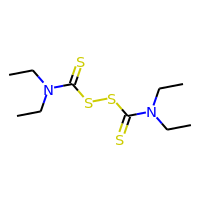
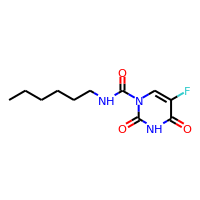
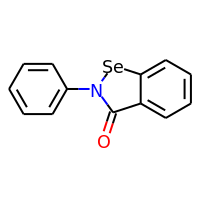
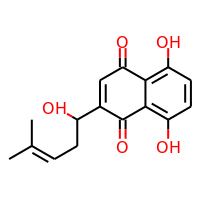
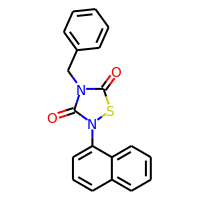

In [19]:
dragon_predictions = pd.concat([moldf, pred], axis=1)
dragon_predictions.head()

# Consensus predictions

In [20]:
sirms = sirms_predictions.rename(columns={'Prediction':'sirms', 'AD': 'sirms_ad'})
dragon = dragon_predictions.rename(columns={'Prediction':'dragon', 'AD': 'dragon_ad'})
predictions = pd.concat([sirms, dragon[['dragon', 'dragon_ad']]], axis=1)
predictions.drop(columns='ID', inplace=True)

In [21]:
predictions['consensus'] = (predictions.sirms + predictions.dragon)/2
predictions['consensus'] = np.where(predictions['consensus'] > 0.5, 1, np.where(predictions['consensus'] < 0.5, 0, np.nan))

for i in range(0, predictions.shape[0]):
    if all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == False]):
        predictions.loc[i,'consensus_ad'] = (predictions.sirms_ad[i] + predictions.dragon_ad[i])/2
        predictions.loc[i,'consensus_ad'] = np.where(predictions.loc[i,'consensus_ad'] > 0.5, 1, np.where(predictions.loc[i,'consensus_ad'] < 0.5, 0, np.nan))
    elif all([np.isnan(predictions.sirms_ad[i]) == True, np.isnan(predictions.dragon_ad[i]) == False]):
        predictions.loc[i,'consensus_ad'] = predictions.dragon_ad[i]
    elif all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == True]):
        predictions.loc[i,'consensus_ad'] = predictions.sirms_ad[i]
    else:
        predictions.loc[i,'consensus_ad']  = np.nan

In [22]:
for col in predictions.columns:
    predictions[col].replace(0,'Inactive',inplace=True)
    predictions[col].replace(1,'Active',inplace=True)

,Compound_name,DRUGBANK_ID,Mol,sirms_ad,sirms,dragon,dragon_ad,consensus,consensus_ad
0,disulfiram,DB00822,,NaN,Inactive,Inactive,Inactive,Inactive,Inactive
1,carmofur,DB09010,,NaN,Inactive,Inactive,NaN,Inactive,NaN
2,ebselen,DB12610,,Inactive,Inactive,Inactive,NaN,Inactive,Inactive
3,shikonin,,,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive
4,tideglusib,DB12129,,NaN,Inactive,Inactive,NaN,Inactive,NaN
5,PX-12,DB05448,,NaN,Inactive,Inactive,NaN,Inactive,NaN
6,TDZD-8,,,Inactive,Inactive,Inactive,NaN,Inactive,Inactive

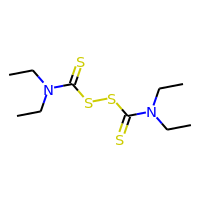
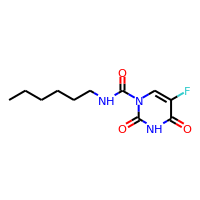
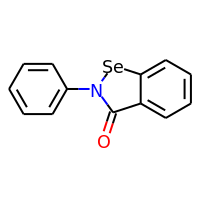
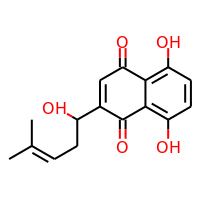
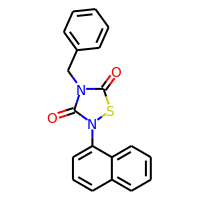
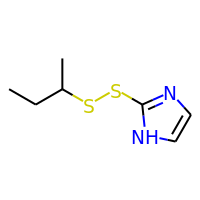
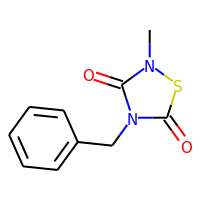

In [23]:
predictions

## Export SDF

In [24]:
PandasTools.WriteSDF(predictions, 'datasets/screened_compounds/new_enz_qsar_pred-sirms-dragon.sdf.gz',
                     molColName='Mol', properties=list(predictions.columns))